In [1]:
import os
import ntpath
import shutil

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
from typing import Callable

In [2]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
X_train = X_train / 255
X_test = X_test / 255

In [3]:
def create_dropout_model(
        activation: str,
        upper_units: int,
        lower_units: int,
        optimizer_name: str = None,
        optimizer_obj: keras.optimizers.Optimizer = None) -> keras.models.Model:
    encoder = keras.models.Sequential([
        keras.layers.Conv2D(16, 4, activation=activation, padding='same', input_shape=(32, 32, 3)),
        keras.layers.MaxPool2D(2),
        keras.layers.Dropout(.5),
        keras.layers.Conv2D(32, 3, activation=activation, padding='same'),
        keras.layers.Flatten(),
        keras.layers.Dense(lower_units, activation=activation)
    ])
    decoder = keras.models.Sequential([
        keras.layers.Dense(upper_units, activation=activation, input_shape=(lower_units,)),
        keras.layers.Dense(32 * 32 * 3, activation='sigmoid'),
        keras.layers.Reshape((32, 32, 3))
    ])
    autoencoder = keras.models.Sequential([encoder, decoder])

    autoencoder.compile(loss='binary_crossentropy', optimizer=optimizer_name or optimizer_obj,
                        metrics=['mse'])

    return autoencoder


def get_callbacks(kind: str) -> (keras.callbacks.EarlyStopping, keras.callbacks.ModelCheckpoint, keras.callbacks.TensorBoard):
    the_name = f'denoising_autoencoder_{kind}'
    patience = 5
    model_dir = os.path.join(os.curdir, 'saved_models')
    run_logdir_root = os.path.join(os.curdir, 'tensor_logs')
    dirs = [
        name
        for name in os.listdir(run_logdir_root)
        if os.path.isdir(os.path.join(run_logdir_root, name)) and name.startswith(name)
    ]
    dirs_count = len(dirs) + 1
    run_logdir = os.path.join(run_logdir_root, f'{the_name}_{dirs_count}')
    early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, min_delta=1e-4)
    model_checkpoint = keras.callbacks.ModelCheckpoint(os.path.join(model_dir, f'{the_name}_{dirs_count}.h5'), save_best_only=True)
    tensorboard = keras.callbacks.TensorBoard(run_logdir, histogram_freq=1, profile_batch=10)

    return early_stopping, model_checkpoint, tensorboard

In [4]:
def fit(autoencoder: keras.models.Model, kind: str):
    early_stopping, model_checkpoint, tensorboard = get_callbacks(kind)

    autoencoder.fit(
        X_train,
        X_train,
        epochs=10,
        validation_data=(X_test, X_test),
        callbacks=[early_stopping, model_checkpoint, tensorboard])

In [16]:
autoencoder1 = create_dropout_model('relu', 512, 32, 'adam')
autoencoder2 = create_dropout_model('relu', 768, 32, 'adam')
autoencoder3 = create_dropout_model('relu', 512, 16, 'adam')
autoencoder4 = create_dropout_model('relu', 768, 16, 'adam')

fit(autoencoder1, 'conv_dropout')
fit(autoencoder2, 'conv_dropout')
fit(autoencoder3, 'conv_dropout')
fit(autoencoder4, 'conv_dropout')

Epoch 1/10
1563/1563 [==============================] - 10s 6ms/step - loss: 0.6119 - mse: 0.0266 - val_loss: 0.6179 - val_mse: 0.0286
Epoch 2/10
1563/1563 [==============================] - 8s 5ms/step - loss: 0.6009 - mse: 0.0219 - val_loss: 0.6172 - val_mse: 0.0280
Epoch 3/10
1563/1563 [==============================] - 8s 5ms/step - loss: 0.5997 - mse: 0.0214 - val_loss: 0.6134 - val_mse: 0.0263
Epoch 4/10
1563/1563 [==============================] - 8s 5ms/step - loss: 0.5993 - mse: 0.0213 - val_loss: 0.6134 - val_mse: 0.0263
Epoch 5/10
1563/1563 [==============================] - 8s 5ms/step - loss: 0.5990 - mse: 0.0212 - val_loss: 0.6122 - val_mse: 0.0258
Epoch 6/10
1563/1563 [==============================] - 7s 5ms/step - loss: 0.5988 - mse: 0.0211 - val_loss: 0.6075 - val_mse: 0.0239
Epoch 7/10
1563/1563 [==============================] - 7s 5ms/step - loss: 0.5986 - mse: 0.0210 - val_loss: 0.6099 - val_mse: 0.0249
Epoch 8/10
1563/1563 [==============================] - 7s 5m

In [42]:
encoder = keras.models.Sequential([
    keras.layers.GaussianNoise(0.1, input_shape=[32, 32, 3]),
    keras.layers.Conv2D(32, kernel_size=3, padding='same', activation='relu'),
    keras.layers.MaxPool2D(),
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
])

encoder.summary()

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gaussian_noise_4 (GaussianN  (None, 32, 32, 3)        0         
 oise)                                                           
                                                                 
 conv2d_11 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 flatten_8 (Flatten)         (None, 8192)              0         
                                                                 
 dense_23 (Dense)            (None, 512)               4194816   
                                                                 
Total params: 4,195,712
Trainable params: 4,195,712
N

In [43]:
decoder = keras.models.Sequential([
    keras.layers.Dense(16 * 16 * 32, activation='relu', input_shape=[512]),
    keras.layers.Reshape([16, 16, 32]),
    keras.layers.Conv2DTranspose(filters=3, kernel_size=3, strides=2, padding='same', activation='sigmoid')
])

decoder.summary()

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 8192)              4202496   
                                                                 
 reshape_13 (Reshape)        (None, 16, 16, 32)        0         
                                                                 
 conv2d_transpose_11 (Conv2D  (None, 32, 32, 3)        867       
 Transpose)                                                      
                                                                 
Total params: 4,203,363
Trainable params: 4,203,363
Non-trainable params: 0
_________________________________________________________________


In [44]:
autoencoder = keras.models.Sequential([encoder, decoder])

autoencoder.compile(loss='binary_crossentropy', optimizer='adam',
                    metrics=['mse'])

fit(autoencoder, 'conv_noise')

Epoch 1/10
1563/1563 [==============================] - 11s 6ms/step - loss: 0.5832 - mse: 0.0144 - val_loss: 0.5869 - val_mse: 0.0145
Epoch 2/10
1563/1563 [==============================] - 9s 6ms/step - loss: 0.5666 - mse: 0.0075 - val_loss: 0.5760 - val_mse: 0.0102
Epoch 3/10
1563/1563 [==============================] - 9s 6ms/step - loss: 0.5635 - mse: 0.0063 - val_loss: 0.5687 - val_mse: 0.0079
Epoch 4/10
1563/1563 [==============================] - 9s 6ms/step - loss: 0.5622 - mse: 0.0059 - val_loss: 0.5674 - val_mse: 0.0074
Epoch 5/10
1563/1563 [==============================] - 9s 6ms/step - loss: 0.5615 - mse: 0.0056 - val_loss: 0.5673 - val_mse: 0.0074
Epoch 6/10
1563/1563 [==============================] - 10s 6ms/step - loss: 0.5610 - mse: 0.0054 - val_loss: 0.5656 - val_mse: 0.0067
Epoch 7/10
1563/1563 [==============================] - 10s 6ms/step - loss: 0.5607 - mse: 0.0053 - val_loss: 0.5650 - val_mse: 0.0065
Epoch 8/10
1563/1563 [==============================] - 10s

In [45]:
result = autoencoder.predict(X_test + np.random.randn(X_test.shape[0], 32, 32, 3) * 0.1)

313/313 [==============================] - 1s 2ms/step


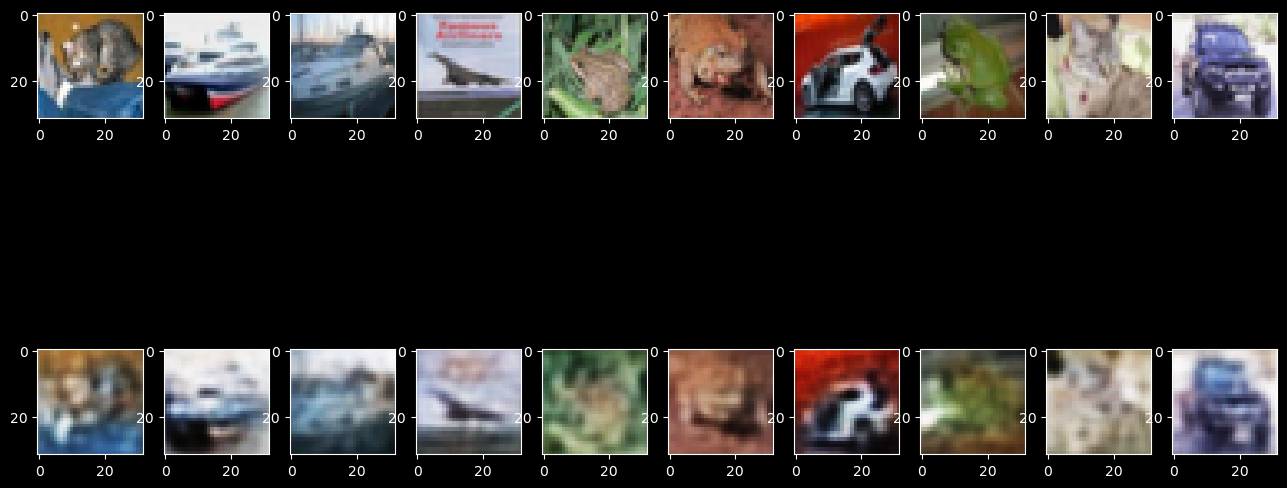

In [46]:
plt.style.use('dark_background')

fig = plt.figure(figsize=(16, 8))
columns = 10
rows = 2
imgs = np.vstack([X_test[:10, :, :], result[:10, :, :]])

for i in range(1, columns * rows + 1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(imgs[i - 1])

plt.show()